<a href="https://colab.research.google.com/github/CptK1ng/dmc2019/blob/alexander_dev/notebooks/alexander_classificator_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificator v1 by Alexander


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, metrics
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

Download our custom Dataset splits:

In [2]:
!wget -nc -q --show-progress https://www.dropbox.com/s/6m8iq9ogpzmu7vx/train_new.csv?dl=1 -O train_new.csv
!wget -nc -q --show-progress https://www.dropbox.com/s/tjpkc45oqn3uv8s/val_new.csv?dl=1 -O val_new.csv

train_new.csv       100%[===================>] 104.09K  --.-KB/s    in 0.09s   
val_new.csv         100%[===================>]  25.96K  --.-KB/s    in 0.04s   


Import Data:

In [3]:
df_train_original = pd.read_csv("train_new.csv", sep="|")
df_val_original = pd.read_csv("val_new.csv", sep="|")
df_train_original.head(2)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,828,66.56,7,4,3,0.007246,0.080386,1.166667,0
1,1,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0


## Feature Engineering

In [84]:
def prepareData(df):
  
  df = df.copy()
  df['trustLevel'] = df['trustLevel']/6 #normalization
  """ this custom feature engineering does not improve the score...
  df['totalLineItems'] = df['scannedLineItemsPerSecond'] * df['totalScanTimeInSeconds'] #nur of scanned products
  # df['totalValue'] = df['valuePerSecond'] * df['totalScanTimeInSeconds'] #this is equal to the column "grandTotal"
  # TODO df['lineItemVoids'] = df['lineItemVoidsPerPosition'] * df['totalLineItemVoidsPositions']
  df['lineItemVoidPercentage'] = df['lineItemVoids'] / (df['totalLineItems'] + df['scansWithoutRegistration'])
  df['totalPositions'] = df['totalLineItems'] - df['lineItemVoids'] # + df['quantityModifications']
  """
  return df

df_train = prepareData(df_train_original)
df_val = prepareData(df_val_original)

#df_train = df_train_original.copy()
#df_val = df_val_original.copy()

df_train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,0.666667,828,66.56,7,4,3,0.007246,0.080386,1.166667,0
1,0.166667,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0
2,0.500000,848,52.37,2,4,0,0.022406,0.061757,0.105263,0
3,0.166667,321,76.03,8,7,2,0.071651,0.236854,0.347826,0
4,0.166667,660,6.06,3,7,1,0.027273,0.009182,0.166667,0


## Split X and Y

In [0]:
# Splitting the final dataset into internal training and testing datasets
df_train_X = df_train.drop('fraud', axis=1)
df_train_y = df_train['fraud']
df_val_X = df_val.drop('fraud', axis=1)
df_val_y = df_val['fraud']
X_train, X_test, y_train, y_test = df_train_X.values, df_val_X.values, df_train_y.values, df_val_y.values

## Simple Classificator


In [86]:
def score_function(y_test, y_pred):
  # return metrics.accuracy_score(y_test, y_pred)
  return metrics.fbeta_score(y_test, y_pred, beta=2)
  # return metrics.f1_score(y_test, y_pred)

def get_accuracy(classifier):
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return score_function(y_test, y_pred)

# Fitting the model and printing the accuracy score
#TODO: 
classifier_sgd = linear_model.SGDClassifier(loss='log', max_iter=4000, tol=1e-3, random_state=0) # Random state is fixed for reproducibility
print("SGD", get_accuracy(classifier_sgd))

SGD 0.15384615384615385


In [87]:
# Printing the confusion matrix
metrics.confusion_matrix(y_test, classifier_sgd.fit(X_train, y_train).predict(X_test))

array([[319,  34],
       [ 19,   4]])

## Other Classificators

In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["KNN (K=3)", "Linear SVM", "RBF SVM", "Gaus. Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Quadr.Dis.A."]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name, "\t\t", get_accuracy(clf))
    

KNN (K=3) 		 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Linear SVM 		 0.0
RBF SVM 		 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Gaus. Process 		 0.0
Decision Tree 		 0.4128440366972477
Random Forest 		 0.05319148936170212
Neural Net 		 0.0
AdaBoost 		 0.6578947368421053
Naive Bayes 		 0.5833333333333333
Quadr.Dis.A. 		 0.7142857142857142


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


##  Boosting Methods

GradBoost 	 0.6756756756756757


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoost 	 0.782608695652174
XGBoost 	 0.7522123893805309


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


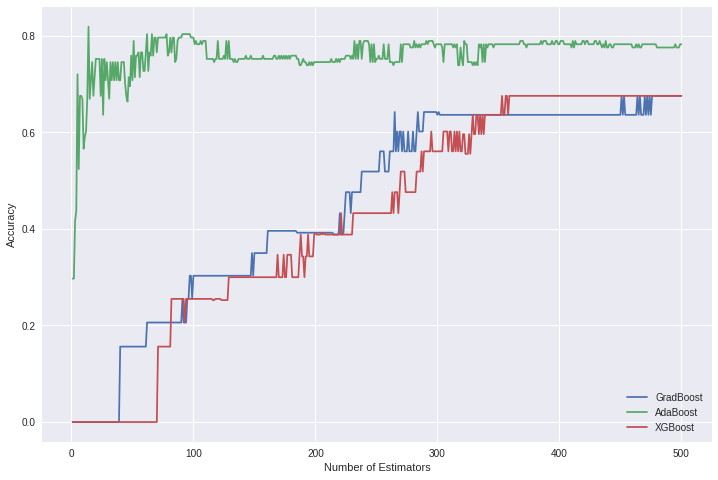

In [89]:
n_estimators=500

# plot the accuracy after each boosting iteration
def get_accuracy_for_n_estimators(classifier):
  accuracy = np.zeros((n_estimators))
  if (isinstance(classifier, XGBClassifier)):
      for i in range(n_estimators):
          classifier = XGBClassifier(n_estimators=i, random_state=1, max_depth=1)
          classifier.fit(X_train, y_train)
          accuracy[i] = score_function(y_test, classifier.predict(X_test))
  else:
      for i, y_pred in enumerate(classifier.staged_predict(X_test)):
          accuracy[i] = score_function(y_test, y_pred)
  return accuracy

 
# GradBoost
classifier_gdb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=1, max_depth=1)
print("GradBoost", "\t", get_accuracy(classifier_gdb) )
accuracy_gdb = get_accuracy_for_n_estimators(classifier_gdb)

# AdaBoost
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators, algorithm='SAMME', random_state=1)
print("AdaBoost", "\t", get_accuracy(classifier_adb) )
accuracy_adb = get_accuracy_for_n_estimators(classifier_adb)

# XGBoost
classifier_xgb = XGBClassifier(e_estimators=n_estimators, random_state=1, max_depth=3)
print("XGBoost", "\t", get_accuracy(classifier_xgb) )
accuracy_xgb = get_accuracy_for_n_estimators(classifier_xgb)

# Plot for each number of estimators
plt.figure(figsize=(12, 8))    
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.plot(np.arange(n_estimators) + 1, accuracy_gdb, label="GradBoost")
plt.plot(np.arange(n_estimators) + 1, accuracy_adb, label="AdaBoost")
plt.plot(np.arange(n_estimators) + 1, accuracy_xgb, label="XGBoost")
plt.legend()
plt.show()

In [90]:
n_estimators = np.argmax(accuracy_adb)+1 # get index of best accuracy

# AdaBoost
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators, algorithm='SAMME', random_state=1)
print("AdaBoost", "\t", get_accuracy(classifier_adb) )


AdaBoost 	 0.8189655172413792


## Pipelined Classificators

### PCA

In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB


classifier_pca = make_pipeline(StandardScaler(), PCA(n_components=5), GaussianNB())
print("PCA", "\t", get_accuracy(classifier_pca) )

PCA 	 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
